In this file we will work the data and prepare it for the modeling phase.

## Import Libraries

In [85]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# import data handling tools
import pandas as pd
import numpy as np
# import data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

### News

In [86]:
# Reddit Data
df_Crypto_Currency_News = pd.read_csv('../Load/Reddit/comments/Crypto_Currency_News_comments.csv')
df_CryptoCurrencies = pd.read_csv('../Load/Reddit/comments/CryptoCurrencies_comments.csv')
df_CryptoCurrency = pd.read_csv('../Load/Reddit/comments/CryptoCurrency_comments.csv')
df_Cryptomarkets = pd.read_csv('../Load/Reddit/comments/Cryptomarkets_comments.csv')
df_eth = pd.read_csv('../Load/Reddit/comments/eth_comments.csv')
df_ethfinance = pd.read_csv('../Load/Reddit/comments/ethfinance_comments.csv')
df_ethtrader = pd.read_csv('../Load/Reddit/comments/ethtrader_comments.csv')

df_reddit = [df_Crypto_Currency_News, df_CryptoCurrencies, df_CryptoCurrency, df_Cryptomarkets, df_eth, df_ethfinance, df_ethtrader]

### Financial Data

In [87]:
# Yahoo Data
df_yahoo = pd.read_csv('../Load/datasets/Yahoo/ETH-USD.csv', delimiter=';')
# Binanace Data
df_BNB_ETH = pd.read_csv('../Load/datasets/Binance/BNB-ETH-klines.csv', delimiter=';')
df_ETH_BTC = pd.read_csv('../Load/datasets/Binance/ETH-BTC-klines.csv', delimiter=';')
df_ETH_USDT = pd.read_csv('../Load/datasets/Binance/ETH-USDT-klines.csv', delimiter=';')
df_XRP_ETH = pd.read_csv('../Load/datasets/Binance/XRP-ETH-klines.csv', delimiter=';')

df_binance = [df_ETH_USDT, df_ETH_BTC, df_BNB_ETH, df_XRP_ETH]

## Transform Dataframes

### Reddit

In [88]:
for df in df_reddit:
    # Drop columns we don't need
    df.drop(['id', 'num_comments', 'permalink', 'score', 'subreddit'], axis=1, inplace=True)
    # Change created_utc format to day/month/year
    df['date'] = pd.to_datetime(df['created_utc'])
    df['date'] = df['date'].dt.strftime('%#d/%#m/%Y')
    # Join title and comments into one column
    # if a comment is empty, replace it with an empty string
    df['title'] = df['title'].astype(str)
    df['comment_1'].fillna('', inplace=True)
    df['comment_1'] = df['comment_1'].astype(str)
    df['comment_2'].fillna('', inplace=True)
    df['comment_2'] = df['comment_2'].astype(str)
    df['comment_3'].fillna('', inplace=True)
    df['comment_3'] = df['comment_3'].astype(str)
    # We use <sos> and <eos> to mark the start and end of a text, this will help training the model
    df['text'] = '<sos> ' + df['title'] + '. ' + df['comment_1'] + '. ' + df['comment_2'] + '. ' + df['comment_3'] + ' <eos>'
    # Drop columns
    df.drop(['created_utc','title', 'comment_1', 'comment_2', 'comment_3'], axis=1, inplace=True)
    
pd.set_option('display.max_rows', None)
df_Crypto_Currency_News.head(11)

,date,text
0,1/10/2019,<sos> Divi Project Update September 2019 Month...
1,1/10/2019,<sos> Interview with the CEO of DIVI Geoff McC...
2,1/10/2019,<sos> Is Wall Street Finally Learning Not To P...
3,1/10/2019,"<sos> In China, a large mining farm burned dow..."
4,1/10/2019,<sos> Bitcoin Bull Run's 'Likely Target' is $2...
5,1/10/2019,"<sos> Vaultoro Integrates Dash, Relaunches Gol..."
6,1/10/2019,<sos> Flixxo's latest article on LATAM Bonds. ...
7,1/10/2019,<sos> Block.One agrees to pay SEC $24 million ...
8,1/10/2019,<sos> Altcoin News: Shady CoinExchange.io Is C...
9,1/10/2019,<sos> Which cryptocurrency do you think will w...


Make a list of all the Dates in our Range

In [89]:
from datetime import datetime,timedelta

start_date = datetime.strptime("1/10/2019","%d/%m/%Y")
end_date = datetime.strptime("30/9/2022","%d/%m/%Y")

# This will create a list with complete dates
completeDates = [start_date + timedelta(days=x) for x in range(0,(end_date-start_date ).days + 1)]
# reformat completeDates from 2019-10-01 00:00:00 to 1/10/2019
completeDates = [date.strftime('%#d/%#m/%Y') for date in completeDates]

Reshape Reddit Dataframes to have one row per Date, with a column for each text

In [90]:
# create dummy dataframes for the 7 reddit dataframes
columns = ['date', 'text_1', 'text_2', 'text_3', 'text_4', 'text_5', 'text_6', 'text_7', 'text_8', 'text_9', 'text_10']
df_Crypto_Currency_News_f = pd.DataFrame(columns=columns)
df_CryptoCurrencies_f = pd.DataFrame(columns=columns)
df_CryptoCurrency_f = pd.DataFrame(columns=columns)
df_Cryptomarkets_f = pd.DataFrame(columns=columns)
df_eth_f = pd.DataFrame(columns=columns)
df_ethfinance_f = pd.DataFrame(columns=columns)
df_ethtrader_f = pd.DataFrame(columns=columns)

# create list of dataframes
df_reddit_f = [df_Crypto_Currency_News_f, df_CryptoCurrencies_f, df_CryptoCurrency_f, df_Cryptomarkets_f, df_eth_f, df_ethfinance_f, df_ethtrader_f]

# get dates from completeDates list
for df in df_reddit_f:
    df['date'] = completeDates

df_Crypto_Currency_News_f.head(3)

,date,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10
0,1/10/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/10/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/10/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Should take around 40 seconds
for i, df in enumerate(df_reddit):
    for day in completeDates:
        df_day = df.loc[df['date'] == day].reset_index(drop=True)
        # get the number of rows
        df_day_len = len(df_day)
        # if there are rows
        if df_day_len > 0:
            for j in range(0, df_day_len):
                text = df_day['text'][j]
                column = 'text_' + str(j+1)
                index = df_reddit_f[i].index[df_reddit_f[i]['date'] == day].values[0]
                df_reddit_f[i].at[index, column] = text

In [92]:
# Remove extra Nan columns
df_reddit_f[2].drop(['text_11', 'text_12', 'text_13'], axis=1, inplace=True)
df_reddit_f[5].drop(['text_11'], axis=1, inplace=True)

In [93]:
for df in df_reddit_f:
    print(df.shape)

(1096, 11)
(1096, 11)
(1096, 11)
(1096, 11)
(1096, 11)
(1096, 11)
(1096, 11)


In [94]:
# For the resulting dataframes, set date as index
for df in df_reddit_f:
    df.set_index('date', inplace=True)

In [95]:
# verify that all dataframes have all the dates
for df in df_reddit_f:
    myDates = df.index.tolist()
    myDates = [d.split()[0] for d in myDates]
    missingDates = [d for d in completeDates if d not in myDates]
    print(len(missingDates))


0
0
0
0
0
0
0


In [96]:
# Lets see the final results of one dataframe
df_Crypto_Currency_News_f.head(2)

,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10
date,,,,,,,,,,
1/10/2019,<sos> Divi Project Update September 2019 Month...,<sos> Interview with the CEO of DIVI Geoff McC...,<sos> Is Wall Street Finally Learning Not To P...,"<sos> In China, a large mining farm burned dow...",<sos> Bitcoin Bull Run's 'Likely Target' is $2...,"<sos> Vaultoro Integrates Dash, Relaunches Gol...",<sos> Flixxo's latest article on LATAM Bonds. ...,<sos> Block.One agrees to pay SEC $24 million ...,<sos> Altcoin News: Shady CoinExchange.io Is C...,<sos> Which cryptocurrency do you think will w...
2/10/2019,<sos> Popular Ethereum App Collapses: How Many...,<sos> Top German Bank Predicts Bitcoin to Hit ...,<sos> UTRUST Integrates Dash Enabling Cryptocu...,<sos> Brazilian Cryptocurrency Exchange Cointr...,<sos> Samsung-Backed Blocko Launches in UAE Af...,<sos> Speaker of the House Challenger Bacelar ...,<sos> Altcoin News: A Large German Bank Predic...,<sos> Trustee of Mt.Gox Is Interested in the C...,<sos> HONG KONG: Why Bitcoin volumes have hit ...,<sos> US State of Ohio Suspends Service for Pa...


In [97]:
df_Crypto_Currency_News_f.tail(2)

,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,text_10
date,,,,,,,,,,
29/9/2022,<sos> Upvote For Upvote. Can Bitcoin break the...,<sos> Audius (AUDIO) Decentralized Music Platf...,"<sos> Smoke Session! Comment ""puff"" for your S...",<sos> Binance Launches Training Program for Go...,<sos> Ribbon Finance has launches ETH-Based Cr...,<sos> ECB Advisor Defends Amazonâ€™s Role in D...,<sos> Brazilâ€™s Securities Market Regulator T...,<sos> win free virtual land on Metaverse. . . ...,<sos> ChainPort adds support for Aurora EVM. T...,<sos> Project for cross-chain bitcoin transfer...
30/9/2022,<sos> Crypto Miners are Ready for the Future. ...,<sos> OKX Reddit Giveaway | You're in ?. . . ...,<sos> MicroStrategy Looks to Hire Software Eng...,<sos> MetaMask Launches New All-In-One Digital...,<sos> How to make MONEY online for FREE in 202...,<sos> Crypto Underworld â€“ Where Crypto Profi...,<sos> Unique Girls - NFT. . . <eos>,<sos> TOP METAVERSE DEVELOPMENT USE CASES PREF...,<sos> ONI is available on Guarda wallet. You c...,<sos> PolkaStation. . . <eos>


In [98]:
# count the average number of words per text and print it
for df in df_reddit_f:
    words = []
    for i in range(1,11):
        column = 'text_' + str(i)
        words.append(df[column].str.split().str.len())
    words = pd.concat(words, axis=1)
    words['avg_words'] = words.mean(axis=1)
    print(words['avg_words'].mean())

18.889004029936675
24.123721176782404
71.79755425979917
27.04819624819625
39.583858998144706
75.10511930553713
45.128344671201816


In [99]:
# check for empty values
df_Crypto_Currency_News_f.isnull().sum()

text_1     131
text_2     131
text_3     131
text_4     132
text_5     133
text_6     133
text_7     133
text_8     134
text_9     134
text_10    135
dtype: int64

In [100]:
# If we don't have news for a day, it is most likely that the sentiment is the same as the previous day
# so we yse ffill to fill empty text values with the previous value
for df in df_reddit_f:
    df.fillna(method='ffill', inplace=True)


In [101]:
df_Crypto_Currency_News_f.isnull().sum()

text_1     0
text_2     0
text_3     0
text_4     0
text_5     0
text_6     0
text_7     0
text_8     0
text_9     0
text_10    0
dtype: int64

### Yahoo & Binance

In [102]:
# No changes needded for Yahoo data
df_yahoo.head()

,date,adj_close,volume
0,1/10/2019,177.340424,7676276225
1,2/10/2019,180.710510,6335595250
2,3/10/2019,175.199341,6381403725
3,4/10/2019,176.985001,6248928449
4,5/10/2019,176.351517,5837211771


In [103]:
for df in df_binance:
    # Drop columns we don't need
    df.drop(['quote_asset_volume', 'taker_buy_quote_asset_volume'], axis=1, inplace=True)
    # For df_ETH_USDT we also drop close, as we have the equivalent in df_yahoo
    if df is df_ETH_USDT:
        df.drop(['close'], axis=1, inplace=True)

# Rename columns
df_ETH_USDT.rename(columns={'num_trades':'num_trades_USDT'}, inplace=True)

df_ETH_BTC.rename(columns={'close':'close_BTC'}, inplace=True)
df_ETH_BTC.rename(columns={'num_trades':'num_trades_BTC'}, inplace=True)

df_BNB_ETH.rename(columns={'close':'close_BNB'}, inplace=True)
df_BNB_ETH.rename(columns={'num_trades':'num_trades_BNB'}, inplace=True)

df_XRP_ETH.rename(columns={'close':'close_XRP'}, inplace=True)
df_XRP_ETH.rename(columns={'num_trades':'num_trades_XRP'}, inplace=True)
# Fix XRP_ETH date format from 01/09/2019 to 1/9/2019
df_XRP_ETH['date'] = df_XRP_ETH['date'].str.replace(r'\b0(\d{1})', r'\1')

df_XRP_ETH.head()

,date,close_XRP,num_trades_XRP
0,1/10/2019,0.001410,5946.0
1,2/10/2019,0.001401,5689.0
2,3/10/2019,0.001413,4310.0
3,4/10/2019,0.001439,4729.0
4,5/10/2019,0.001437,4356.0


In [104]:
# Join yahoo and binance dataframes on equal dates
df_finance = pd.merge(df_yahoo, df_ETH_USDT, on='date', how='left')
df_finance = pd.merge(df_finance, df_ETH_BTC, on='date', how='left')
df_finance = pd.merge(df_finance, df_BNB_ETH, on='date', how='left')
df_finance = pd.merge(df_finance, df_XRP_ETH, on='date', how='left')

# in case any dates duplicate, we drop them
df_finance.drop_duplicates(subset='date', keep='first', inplace=True)

# set date as index
df_finance.set_index('date', inplace=True)
df_finance.index = pd.to_datetime(df_finance.index, format="%d/%m/%Y")

df_finance.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
2019-10-01,177.340424,7676276225,168492,0.021182,133240,0.090262,11802,0.001410,5946.0
2019-10-02,180.710510,6335595250,96660,0.021566,92471,0.088028,7465,0.001401,5689.0
2019-10-03,175.199341,6381403725,101114,0.021241,87748,0.089504,7160,0.001413,4310.0
2019-10-04,176.985001,6248928449,89655,0.021580,87725,0.089029,6246,0.001439,4729.0
2019-10-05,176.351517,5837211771,90341,0.021682,93049,0.089143,5373,0.001437,4356.0


In [105]:
# verify that all dates are present
myDates = df_finance.index.tolist()
myDates = [d.strftime('%#d/%#m/%Y') for d in myDates]
missingDates = [d for d in completeDates if d not in myDates]
print(len(missingDates))

0


#### Explaining vairables
**closes**
- adj_close and close_BTC is the price of ETH relative to USD and BTC respectively. If adj_close = 1328 and close_BTC = 0.068, then 1 ETH is worth 1328 USD and 0.068 BTC.
- close_BNB and close_XRP is the price of BNB and XRP in ETH, the other way around. If close_BNB = 0.021 close_XRP = 0.00036, then 1 BNB is worth 0.021 ETH and 1 XRP is worth 0.00036 ETH.

**volume**
- Shows how much was traded on each exchange where ETH-USD is listed. It is an indicator of its popularity as well as market sentiment.

**num_trades**
- Number of trades is the number of trades that happened that day between ETH and the other coin in Binance

In [106]:
# check for empty values
df_finance.isnull().sum()

adj_close           0
volume              0
num_trades_USDT     0
close_BTC           0
num_trades_BTC      0
close_BNB           0
num_trades_BNB      0
close_XRP          61
num_trades_XRP     61
dtype: int64

In [107]:
# Fill empty values with interpolation, fills with the average of the previous and next values
df_finance['close_XRP'] = df_finance['close_XRP'].interpolate(method='time')
df_finance['num_trades_XRP'] = df_finance['num_trades_XRP'].interpolate(method='time')

In [108]:
df_finance.isnull().sum()

adj_close          0
volume             0
num_trades_USDT    0
close_BTC          0
num_trades_BTC     0
close_BNB          0
num_trades_BNB     0
close_XRP          0
num_trades_XRP     0
dtype: int64

In [109]:
# fix index format from 2019-10-01 to 1/10/2019
df_finance.index = df_finance.index.strftime('%#d/%#m/%Y')

In [110]:
df_finance.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
1/10/2019,177.340424,7676276225,168492,0.021182,133240,0.090262,11802,0.001410,5946.0
2/10/2019,180.710510,6335595250,96660,0.021566,92471,0.088028,7465,0.001401,5689.0
3/10/2019,175.199341,6381403725,101114,0.021241,87748,0.089504,7160,0.001413,4310.0
4/10/2019,176.985001,6248928449,89655,0.021580,87725,0.089029,6246,0.001439,4729.0
5/10/2019,176.351517,5837211771,90341,0.021682,93049,0.089143,5373,0.001437,4356.0


In [111]:
df_finance.tail()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
date,,,,,,,,,
26/9/2022,1335.320190,16034549271,934159,0.069505,275490,0.2066,23684,0.000350,15980.0
27/9/2022,1330.127686,17870598937,1055212,0.069609,356483,0.2050,29137,0.000335,14991.0
28/9/2022,1337.410889,18994979566,1075441,0.068884,404236,0.2105,37346,0.000336,13145.0
29/9/2022,1335.652344,13796915736,950476,0.068188,325040,0.2126,29551,0.000365,17534.0
30/9/2022,1327.978638,14250100093,926935,0.068412,345607,0.2143,28865,0.000361,21250.0


In [112]:
df_finance.shape

(1096, 9)

#### Min-Max  Normalization

In [113]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# To avoid data tampering
df_finance_n = df_finance

normalized_data = scaler.fit_transform(df_finance_n)

df_normalized = pd.DataFrame(normalized_data, columns=df_finance_n.columns)

df_normalized.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,0.014194,0.032344,0.018899,0.054027,0.065738,0.241343,0.025332,0.796025,0.034727
1,0.014911,0.015453,0.005801,0.059471,0.030083,0.232387,0.012731,0.790415,0.032910
2,0.013739,0.016030,0.006613,0.054863,0.025952,0.238304,0.011845,0.798080,0.023161
3,0.014119,0.014361,0.004524,0.059669,0.025932,0.236400,0.009190,0.815287,0.026123
4,0.013984,0.009174,0.004649,0.061115,0.030588,0.236857,0.006653,0.813421,0.023486


In [114]:
print(df_normalized.describe())
adj_mean = df_normalized.describe()['adj_close'][1]
adj_std = df_normalized.describe()['adj_close'][2]
vol_mean = df_normalized['volume'].mean()
vol_std = df_normalized['volume'].std()


         adj_close       volume  num_trades_USDT    close_BTC  num_trades_BTC  \
count  1096.000000  1096.000000      1096.000000  1096.000000     1096.000000   
mean      0.315593     0.171793         0.135230     0.427116        0.135854   
std       0.284625     0.128720         0.115266     0.312391        0.115812   
min       0.000000     0.000000         0.000000     0.000000        0.000000   
25%       0.028541     0.087898         0.040417     0.120362        0.056091   
50%       0.289928     0.143725         0.119327     0.309396        0.104162   
75%       0.550286     0.220025         0.191852     0.735738        0.177438   
max       1.000000     1.000000         1.000000     1.000000        1.000000   

         close_BNB  num_trades_BNB    close_XRP  num_trades_XRP  
count  1096.000000     1096.000000  1096.000000     1096.000000  
mean      0.352341        0.082412     0.269298        0.068105  
std       0.179604        0.093755     0.285207        0.089525  
min   

#### Dummy Dataframe

In [115]:

data = {
    'date': ['2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01', '2019-10-01'],
    'adj_close': [175.2343, 178.234, 177.1234, 179.2432, 180.2341],
    'volume': [5775236244, 6481347253, 7238928455, 5555551771, 7445266224],
    'num_trades_USDT': [168492, 96660, 101114, 89655, 90341],
    'close_BNB': [0.090262, 0.088262, 0.089262, 0.089143, 0.097444],
    'num_trades_BNB': [5218, 4231, 10111, 6828, 8543],
    'close_XRP': [0.001418, 0.001401, 0.001438, 0.001437, 0.001429],
    'num_trades_XRP': [6542, 4532, 5345, 6432, 5823]
}
normalized= {}
unnormalized = {}

# normalize for each key in data
for key in data:
    if key != 'date':
        mean = df_finance[key].mean()
        std = df_finance[key].std()
        unnormalized[key] = [(x - mean) / std for x in data[key]]
        mean_normalized = df_normalized[key].mean()
        std_normalized = df_normalized[key].std()
        normalized[key] = [(x - mean_normalized) / std_normalized for x in data[key]]

df_normalized_m = pd.DataFrame(normalized)
df_unnormalized = pd.DataFrame(unnormalized)

print("***Normalized using mean and std of the df_normalized dataset***")
print(df_normalized_m.head())
print("***Normalized using mean and std of the df_finance dataset***")
print(df_unnormalized.head())
print("***Original normalized data***")
print(df_normalized.head())


***Normalized using mean and std of the df_normalized dataset***
    adj_close        volume  num_trades_USDT  close_BNB  num_trades_BNB  \
0  614.558710  4.486667e+10     1.461762e+06  -1.459201    55654.778072   
1  625.097845  5.035230e+10     8.385790e+05  -1.470337    45127.347344   
2  621.195867  5.623780e+10     8.772200e+05  -1.464769   107843.955937   
3  628.643564  4.315998e+10     7.778067e+05  -1.465431    72827.182806   
4  632.124989  5.784080e+10     7.837581e+05  -1.419213    91119.526979   

   close_XRP  num_trades_XRP  
0  -0.939248    73073.749664  
1  -0.939308    50621.935861  
2  -0.939178    59703.191892  
3  -0.939182    71845.043436  
4  -0.939210    65042.478955  
***Normalized using mean and std of the df_finance dataset***
   adj_close    volume  num_trades_USDT  close_BNB  num_trades_BNB  close_XRP  \
0  -1.060507 -1.269422        -1.009239  -0.618014       -0.812847   1.865415   
1  -1.058266 -1.200311        -1.122873  -0.662655       -0.843434   1.826

## Data Visualization

In [116]:
# Visualize the complete news from Crypto_Currency_News_f for a specific date
# These are very long strings, so to print them we need to use the following function
pd.set_option('display.max_colwidth', None)
# print it pretty
df_eth_f.loc['1/10/2019']

text_1     <sos> Gradbase putting qualifications on the Ethereum Blockchain. In my opinion I think this is a very solid use case.. This is indeed a very good use case of Blockchain technology in general.\n\nThe qualification verification procedures of today are dire. If you wanted to verify the authenticity of a degree or work experience you would in 99.9% of cases know who/what office to contact at the issuing institution. This is before you take into account the eventual language barrier and international payment that may have to be made. Moreover, every institution uses their own method (typically slow and manual) to accept requests and fulfil them. I've seen companies not perform employee checks at all because the system is simply impossible to navigate.\n\nThis is because there is zero standardisation in this sector, and all data is stored in different siloed databases at the institution's end.\n\nAt a talk in London, UK last year, Vitalik expressed his support for using Ethereum 

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

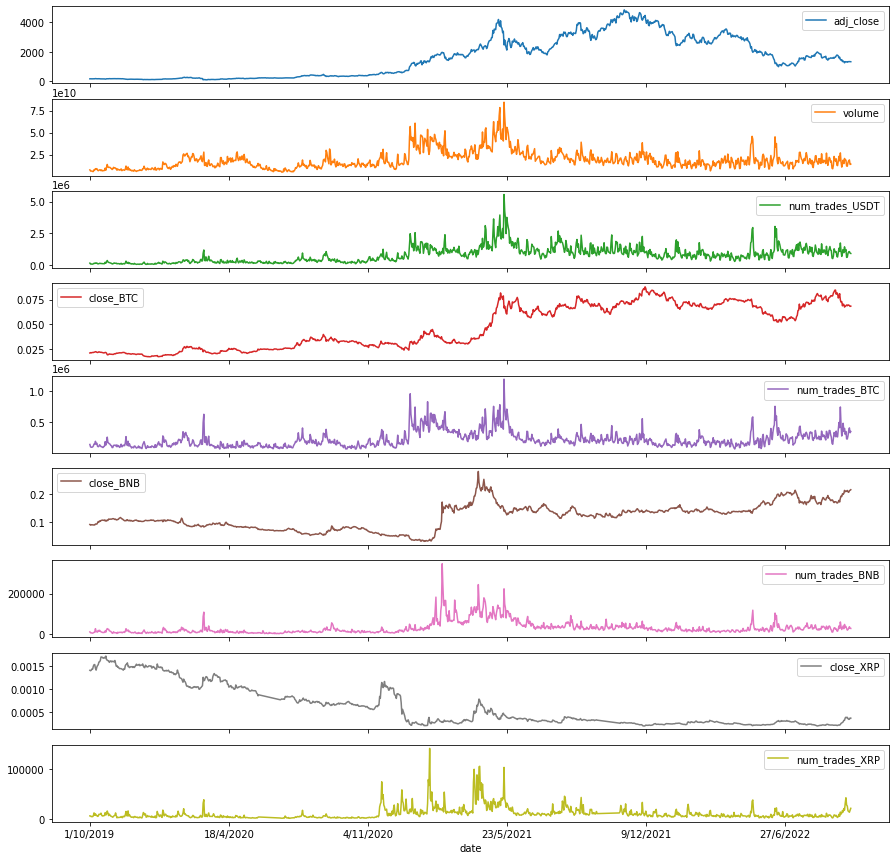

In [117]:
# subplot every numeric column
df_finance.plot(subplots=True, figsize=(15, 15))